In [1]:
import dask.distributed
from pystac_client import Client
import planetary_computer
import xarray as xr
import odc.stac
import rioxarray
import geopandas as gpd

# Initialize Dask distributed client
client = dask.distributed.Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 16,Total memory: 23.70 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:49843,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 23.70 GiB
Comm: tcp://127.0.0.1:49865,Total threads: 4
Dashboard: http://127.0.0.1:49871/status,Memory: 5.93 GiB
Nanny: tcp://127.0.0.1:49846,


In [2]:
BBOX = [8.3546304700001315, 50.6733055120000699, 9.1515865320000671, 50.9967079160001617]
LANDSAT_COLLECTION = "landsat-c2-l2"
DATETIME = ("1990-01-01", "2001-02-14")

catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

# Use an operator (eq) for the query:
item_search = catalog.search(
    collections=[LANDSAT_COLLECTION],
    bbox=BBOX,
    datetime=DATETIME,
    query={"platform": {"eq": "landsat-5"}},
)

item_collection = planetary_computer.sign_item_collection(item_search.item_collection())

print(f"Found {len(item_collection)} Landsat-5 TM items.")

ds = odc.stac.load(
    item_collection,
    bands=["red", "nir08", "swir16", "swir22", "qa_pixel"],
    bbox=BBOX,
    #crs="epsg:4326",
    chunks={'time': 10, 'x': 500, 'y': 500}, #Load the data lazily with specified chunk sizes. This is critical for memory-efficient processing, especially when working with large datasets.
    resolution=30,
)

Found 833 Landsat-5 TM items.


In [3]:
# Extract the qa_pixel band, where each pixel's value encodes quality information as bit flags.
qa_pixel = ds["qa_pixel"]

# Define bit flags
DILATED_CLOUD_FLAG = 1 << 1  # Dilated Cloud bit flag: Binary 0b10 (decimal 2¹=2)
CIRRUS_FLAG = 1 << 2  # Cirrus bit flag: Binary 0b100 (decimal 2²=4)
CLOUD_FLAG = 1 << 3  # Cloud bit flag: Binary 0b1000 (decimal 2³=8)
SHADOW_FLAG = 1 << 4  # Cloud Shadow bit flag: Binary 0b10000 (decimal 2⁴=16)

# Create a mask for good pixels (The bitwise & operation checks if a specific flag is set for a pixel.)
good_pixels = (
    ((qa_pixel & DILATED_CLOUD_FLAG) == 0) &  # Exclude dilated clouds. Check if the DILATED_CLOUD_FLAG bit is set. Comparing this result to 0 ensures that the flag is not set.
    ((qa_pixel & CIRRUS_FLAG) == 0) &  # Exclude cirrus clouds
    ((qa_pixel & CLOUD_FLAG) == 0) &  # Exclude clouds
    ((qa_pixel & SHADOW_FLAG) == 0)  # Exclude cloud shadows
)

In [4]:
# Apply the mask to the dataset
bands_todo = ["red", "nir08", "swir16", "swir22"] # Adjust according to your dataset's bands
for band in bands_todo:
    ds[band] = ds[band].where(good_pixels)

In [5]:
# Initialize a DataArray to keep track of valid scenes
# This array keeps track of which time steps have valid data. It starts with all False.
scenes_to_keep = xr.zeros_like(ds['time'], dtype=bool)

# Loop through each band and check for any non-NaN values across the spatial dimensions
for band in bands_todo:  # Adjust according to your dataset's bands
    # Check for non-NaN values in the current band across 'x' and 'y' dimensions
    valid_pixels = ds[band].notnull().any(dim=['x', 'y'])
    # Result: A 1D boolean array with True for time steps where there are non-NaN values in the current band.

    # Updates scenes_to_keep to include time steps with valid data in any of the bands.
    scenes_to_keep = scenes_to_keep | valid_pixels

# Compute the boolean mask and filter the dataset to only keep non-empty scenes.
ds_filtered = ds.sel(time=ds['time'][scenes_to_keep.compute()]) # compute() executes the lazy computation of the boolean mask. Check the Dask status monitor for any actions.

In [6]:
comp = dict(zlib=True, complevel=4)
ds.encoding.update(comp)
ds.encoding.get('complevel')

ds.to_netcdf(r'test.nc')

In [2]:
dataset = xr.open_dataset('test.nc')

In [3]:
print(dataset)

<xarray.Dataset> Size: 34GB
Dimensions:      (y: 1206, x: 1878, time: 833)
Coordinates:
  * y            (y) float64 10kB 5.65e+06 5.65e+06 ... 5.614e+06 5.614e+06
  * x            (x) float64 15kB 4.544e+05 4.544e+05 ... 5.107e+05 5.107e+05
  * time         (time) datetime64[ns] 7kB 1990-01-20T09:44:13.914081 ... 200...
Data variables:
    spatial_ref  int32 4B ...
    red          (time, y, x) float32 8GB ...
    nir08        (time, y, x) float32 8GB ...
    swir16       (time, y, x) float32 8GB ...
    swir22       (time, y, x) float32 8GB ...
    qa_pixel     (time, y, x) uint16 4GB ...


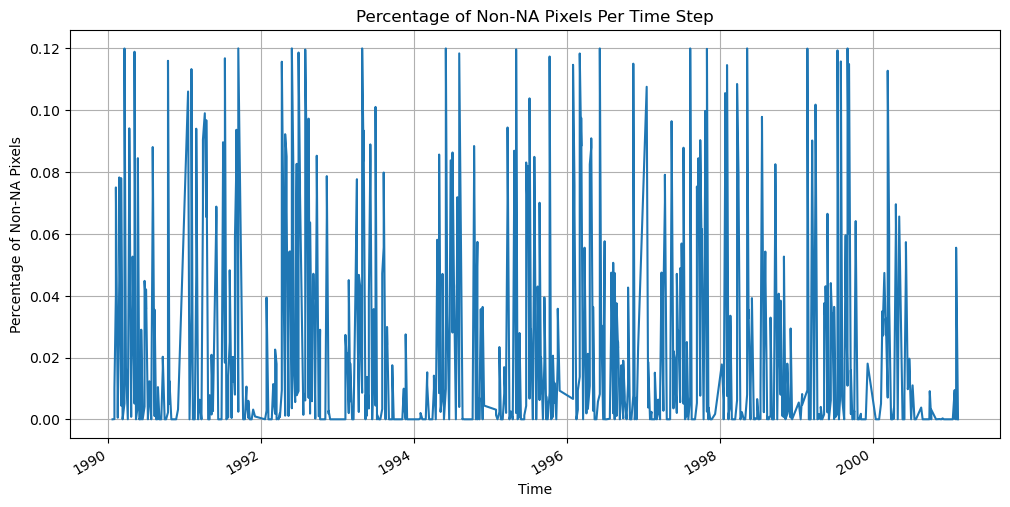

In [4]:
import xarray as xr
import matplotlib.pyplot as plt

# Load the dataset (assuming it's already opened as `dataset`)
# Calculate NDVI
dataset['NDVI'] = (dataset['nir08'] - dataset['red']) / (dataset['nir08'] + dataset['red'])

# Calculate the percentage of non-NA pixels per time step
non_na_percentage = (
    dataset['NDVI'].notnull().sum(dim=['x', 'y']) / dataset['NDVI'].size
) * 100

# Create a DataArray for easier plotting
non_na_timeseries = non_na_percentage.to_series()

# Plot the percentage of non-NA pixels per time step
plt.figure(figsize=(12, 6))
non_na_timeseries.plot()
plt.title("Percentage of Non-NA Pixels Per Time Step")
plt.xlabel("Time")
plt.ylabel("Percentage of Non-NA Pixels")
plt.grid()
plt.show()


In [12]:
dataset['red']


<xarray.DataArray 'red' (time: 5, latitude: 1, longitude: 1)> Size: 10B
[5 values with dtype=uint16]
Coordinates:
  * latitude   (latitude) float64 8B 45.0
  * longitude  (longitude) float64 8B 15.0
  * time       (time) datetime64[ns] 40B 1999-01-13T10:00:52.983050 ... 1999-...
Attributes:
    nodata:        0
    grid_mapping:  spatial_ref